## Initial Logistic Regression Training 

In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

df = pd.read_csv('/Users/p.devine/Documents/GitHub/Academic-Success-Predictor/data/df_vif_cleaned.csv')

X = df.drop(columns=['result_pass'])

y = df['result_pass'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.6846
Confusion Matrix:
[[28 29]
 [12 61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.49      0.58        57
           1       0.68      0.84      0.75        73

    accuracy                           0.68       130
   macro avg       0.69      0.66      0.66       130
weighted avg       0.69      0.68      0.67       130



## Feature Importance

In [15]:
# Train a logistic regression model with L1 regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train, y_train)

importance = np.abs(model_l1.coef_).flatten()
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

#L1 (lasso) Regularisation to see which features matters most

              Feature  Importance
8              higher    1.843082
2            failures    1.679939
3           schoolsup    1.309563
20       Mjob_at_home    0.981452
15          school_MS    0.912927
32    guardian_mother    0.528260
6          activities    0.485636
16              sex_M    0.443444
1           studytime    0.390875
11               Dalc    0.322661
29        reason_home    0.318251
17          address_U    0.274448
26      Fjob_services    0.265958
23       Mjob_teacher    0.122493
18        famsize_LE3    0.113061
24       Fjob_at_home    0.098983
0          traveltime    0.097268
13             health    0.096994
9            internet    0.091605
27       Fjob_teacher    0.087939
5                paid    0.087124
30  reason_reputation    0.080329
14           absences    0.071873
28      reason_course    0.069021
4              famsup    0.063101
12               Walc    0.033796
7             nursery    0.020396
25        Fjob_health    0.000000
22      Mjob_s

In [16]:
print(df["result_pass"].value_counts())

result_pass
1    348
0    301
Name: count, dtype: int64


## Introduction of SMOTE

In [17]:
df2 = df.drop(columns = [ 'famsup', 'Fjob_health', 'Pstatus_T', 'nursery', 'reason_reputation', 'romantic', 'Walc', 'guardian_father', 'Mjob_health', 'Mjob_services', 'reason_course', 
                         'reason_reputation'])
X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_smote, y_train_smote)

y_pred_best = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

print("Misclassified: ")

misclassified = X_test[y_test != y_pred_best]
misclassified['actual_label'] = y_test[y_test != y_pred_best]
misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]

print(misclassified.describe())
print(misclassified.groupby('actual_label').mean())


Accuracy: 0.7230769230769231
Confusion Matrix:
 [[33 24]
 [12 61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        57
           1       0.72      0.84      0.77        73

    accuracy                           0.72       130
   macro avg       0.73      0.71      0.71       130
weighted avg       0.72      0.72      0.72       130

Misclassified: 
       traveltime  studytime   failures  schoolsup       paid  activities  \
count   36.000000  36.000000  36.000000  36.000000  36.000000   36.000000   
mean     1.472222   1.972222   0.055556   0.194444   0.027778    0.361111   
std      0.736250   0.909823   0.232311   0.401386   0.166667    0.487136   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.00000

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/3169840758.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual_label'] = y_test[y_test != y_pred_best]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/3169840758.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]


## Feature Engineering

In [22]:
df2['studytime_failures'] = df2['studytime'] * df2['failures']
#df2['paid_schoolsup'] = df2['paid'] * df2['schoolsup']
df2['health_absences'] = df2['health'] * df2['absences']
df2['absences_studytime'] = df2['absences'] * df2['studytime']
df2['Dalc_health'] = df2['Dalc'] * df2['health']
df2['traveltime_schoolsup'] = df2['traveltime'] * df2['schoolsup']

X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print("Misclassified: ")

misclassified = X_test[y_test != y_pred_best]
misclassified['actual_label'] = y_test[y_test != y_pred_best]
misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]

print(misclassified.describe())
print(misclassified.groupby('actual_label').mean())

Accuracy: 0.7384615384615385
Confusion Matrix:
 [[33 24]
 [10 63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.58      0.66        57
           1       0.72      0.86      0.79        73

    accuracy                           0.74       130
   macro avg       0.75      0.72      0.72       130
weighted avg       0.74      0.74      0.73       130

Misclassified: 
       traveltime  studytime   failures  schoolsup       paid  activities  \
count   36.000000  36.000000  36.000000  36.000000  36.000000   36.000000   
mean     1.472222   1.972222   0.055556   0.194444   0.027778    0.361111   
std      0.736250   0.909823   0.232311   0.401386   0.166667    0.487136   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.00000

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/2591099377.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual_label'] = y_test[y_test != y_pred_best]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/2591099377.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]


## K-Fold Validation

In [23]:
classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

kfold = KFold(5, shuffle = True, random_state =42)
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    print(f"Fold {i}:")
    print(f" Train: index={train_index}")
    print(f" Test: index={test_index}")

scores = cross_val_score(classifier, X ,y, cv=kfold, scoring = 'accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score,4) for score in scores]}")
print(f"Average accuracy across 10 folds: {average_acc: .2f}")

Fold 0:
 Train: index=[  0   1   3   4   5   7   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  25  26  27  28  29  32  33  34  35  36  37  38  40  42  43
  45  46  47  48  50  51  52  53  57  58  59  61  62  64  66  67  68  71
  73  74  75  79  80  83  84  85  87  88  89  91  92  93  94  95  96  97
  98  99 100 102 103 104 105 106 107 111 112 113 114 115 116 117 119 120
 121 122 123 124 125 126 127 128 129 130 134 136 137 138 139 140 141 142
 143 144 146 147 149 150 151 152 153 154 155 156 157 159 160 161 162 164
 166 168 169 170 171 172 173 175 178 179 180 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 205 206 207
 208 211 213 214 216 217 219 221 222 223 224 225 226 227 228 229 230 232
 233 234 235 236 237 238 239 240 241 242 243 245 246 248 250 251 252 253
 254 255 256 258 259 260 261 262 263 266 267 269 270 272 273 274 275 276
 278 279 280 282 283 284 285 286 287 288 289 290 291 293 294 295 296 297
 299 301 302 303 304 305 306 

In [24]:
X = df2.drop(columns=['result_pass', 'internet', 'Dalc_health', 'absences', 'famsize_LE3'])
y = df2['result_pass']

smote = SMOTE(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

print("Average Accuracy: {:.4f}".format(avg_accuracy))
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))

print("Misclassified: ")

misclassified = X_val[y_val != y_pred]
misclassified['actual'] = y_val[y_val != y_pred]
misclassified['predicted'] = y_pred[y_val != y_pred]

print(misclassified.describe())
print(misclassified.groupby('actual').mean())



Average Accuracy: 0.7349
Average Confusion Matrix:
 [[41.2 19. ]
 [15.4 54.2]]
Average Classification Report (accuracy): 0.7349
Misclassified: 
       traveltime  studytime   failures  schoolsup       paid  activities  \
count   38.000000  38.000000  38.000000  38.000000  38.000000   38.000000   
mean     1.552632   1.894737   0.052632   0.105263   0.052632    0.394737   
std      0.760418   0.831458   0.226294   0.311012   0.226294    0.495355   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.000000   0.000000   0.000000   0.000000    1.000000   
max      4.000000   4.000000   1.000000   1.000000   1.000000    1.000000   

          higher       Dalc     health  school_MS  ...  Fjob_services  \
count  38.000000  38.000000  38.000000  38.000000  ...      38.000000   
mean    0.947368

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/3524684087.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual'] = y_val[y_val != y_pred]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_72282/3524684087.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted'] = y_pred[y_val != y_pred]


## Hyperparameter Tuning

In [26]:
X = df2.drop(columns=['result_pass', 'health_absences', 'internet', 'Dalc_health', 'absences',
                      'traveltime', 'higher'])
y = df2['result_pass']

# SMOTE used to boost recall score for class 0 (fail), due to slight imbalance by creating synthetic examples
smote = SMOTE(random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],                    #l1 (Lasso), l2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

best_params = None
best_score = 0
accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kfold.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression()
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,  
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_smote, y_train_smote)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

    best_logistic_model = grid_search.best_estimator_
    best_logistic_model.fit(X_train_smote, y_train_smote)

    y_pred = best_logistic_model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

df_results = pd.DataFrame(grid_search.cv_results_)

top_10_results = df_results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 
                             'mean_test_score', 'std_test_score', 'rank_test_score']]\
                    .sort_values(by='rank_test_score')\
                    .head(10)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_score:.4f}")
print(f"Average Test Accuracy: {avg_accuracy:.4f}")
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))
print("\nTop 10 Hyperparameter Configurations:\n", top_10_results)

Best Hyperparameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy: 0.7353
Average Test Accuracy: 0.7395
Average Confusion Matrix:
 [[40.8 19.4]
 [14.4 55.2]]
Average Classification Report (accuracy): 0.7395

Top 10 Hyperparameter Configurations:
    param_penalty  param_C param_solver  param_max_iter  mean_test_score  \
6             l2     0.01    liblinear           10000         0.735253   
7             l2     0.01         saga           10000         0.729766   
11            l2     0.10         saga           10000         0.709225   
10            l2     0.10    liblinear           10000         0.707373   
18            l2    10.00    liblinear           10000         0.698131   
15            l2     1.00         saga           10000         0.696313   
17            l1    10.00         saga           10000         0.696296   
14            l2     1.00    liblinear           10000         0.694478   
21            l1   100.00   

## Model Finalisation

Final Model Test Accuracy: 0.7308
Final Confusion Matrix:
 [[34 23]
 [12 61]]
Final Classification Report (accuracy): 0.7308
Final Classification Report Scores:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        57
           1       0.72      0.84      0.77        73

    accuracy                           0.72       130
   macro avg       0.73      0.71      0.71       130
weighted avg       0.72      0.72      0.72       130



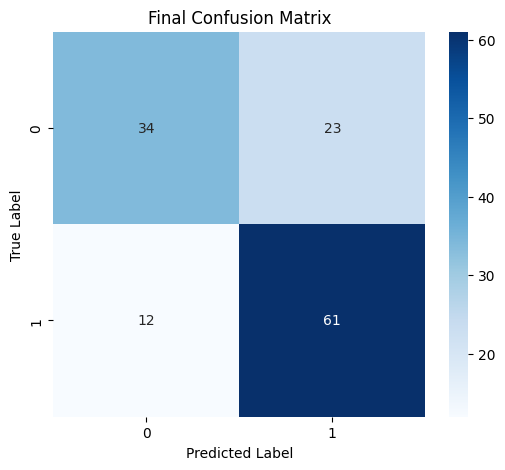

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

final_model = LogisticRegression(
    penalty=best_params['penalty'], 
    C=best_params['C'], 
    solver=best_params['solver'], 
    max_iter=best_params['max_iter']
)

final_model.fit(X_train_smote, y_train_smote)

y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Test Accuracy: {final_accuracy:.4f}")

cm_final = confusion_matrix(y_test, y_pred_final)
print("Final Confusion Matrix:\n", cm_final)

class_report_final = classification_report(y_test, y_pred_final, output_dict=True)
print("Final Classification Report (accuracy): {:.4f}".format(class_report_final['accuracy']))
print("Final Classification Report Scores:\n", classification_report(y_test, y_pred_best))

plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Final Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

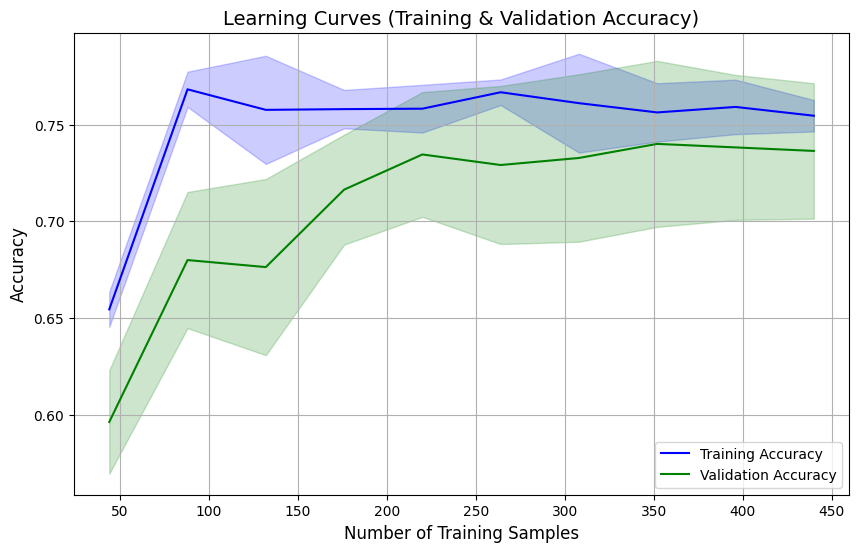

In [28]:
train_sizes, train_scores, val_scores = learning_curve(
    final_model, 
    X_train_smote, 
    y_train_smote, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,  
    n_jobs=-1,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='green')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

plt.title('Learning Curves (Training & Validation Accuracy)', fontsize=14)
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

plt.show()
